### Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric 
from torch_geometric.datasets import GeometricShapes
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np

import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

from gnnexplainer.explain import Explainer,ExplainModule
# from torch_geometric.nn import  GNNExplainer

Using backend: pytorch


### Load Dataset

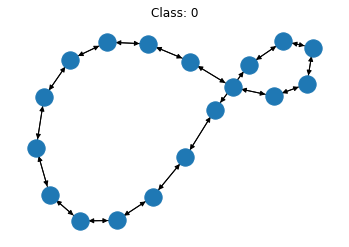

In [2]:

# A dataset with 80 samples, each graph is
# of size [10, 20]
trainset = MiniGCDataset(600, 12, 20)
testset = MiniGCDataset(60, 12, 20)
graph, label = trainset[2]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

### Net Definition

In [3]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

train_data_loader = DataLoader(trainset, batch_size=1, shuffle=True,collate_fn=collate)

traindata=[]
for iter, (g,label) in enumerate(train_data_loader):
    if(label == 5):
        traindata.append((g,0))
    if(label == 7):
        traindata.append((g,1))   

In [4]:
class Net(torch.nn.Module):
    def __init__(self,in_dim, hidden_dim, n_classes):
        super(Net, self).__init__()
#         self.lin = Sequential(Linear(10, 10))
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, x, edge_index):
        h1 = F.relu(self.conv1(x, edge_index))
        h2 = F.dropout(h1, training=self.training)
        h3 = F.relu(self.conv2(h2, edge_index))
        y = torch.mean(h3, 0, True)
        return self.classify(y),h1,h2,h3

### Training

In [5]:
training_epoch = 300 #original = 1500 for 1 training sample 500 for 20 samples
initial_lr = 0.001

model_name = 'explaingraph_epoch30005-May-2020-13:32:24'

# model_name = '4-class-model_10-samples_500-epoch_acc-99.500000_1-errs_12-Apr-2020-14:35:45'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_PATH = './models/' + model_name
model = Net(1, 256, 2).to(device)
optimizer = optim.SGD(model.parameters(), lr = initial_lr, momentum=0.9, weight_decay=5e-4)
checkpoint = torch.load(SAVE_PATH)
checkpoint = torch.load(SAVE_PATH)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
# loss = checkpoint['loss']
print(device)
training=''

cuda


In [6]:
# Create model
#model = Classifier(1, 256, trainset.num_classes)
import time
from datetime import datetime
if (training=='New'):
    model = Net(1, 256, 2).to(device)
    loss_func = nn.CrossEntropyLoss()

    

    model.train()

    epoch_losses = []

    #start timer:
    t0 = time.time()

    for epoch in range(training_epoch):
        model.train()
        epoch_loss = 0
        for iter, (g,label) in enumerate(traindata):
            x = g.in_degrees().view(-1, 1).float().to(device)

#             x = torch.ones(g.batch_num_nodes[0],1).cuda()
            a = g.edges()[0].tolist()
            b = g.edges()[1].tolist()
            edges = list(zip(a,b))
            edges = np.array(edges)
            edges = torch.LongTensor(edges.transpose()).to(device)
            labels = np.array([label])

            prediction,h1,h2,h3 = model(x,edges)
            loss = loss_func(prediction, torch.LongTensor(labels).cuda())
            optimizer.zero_grad()
            loss.backward()
    #         print('loss {:.4f},label:{}'.format(loss,label))
            optimizer.step()
            epoch_loss += loss.detach().item()
        epoch_loss /= (iter + 1)
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
        epoch_losses.append(epoch_loss)

    training_time = time.time() - t0

    print('Finished training. Training time = {:.4f} Seconds'.format(training_time))


    dateTimeObj = datetime.now()

    timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H:%M:%S")
    model_name = 'explaingraph_epoch{}'.format(training_epoch)+timestampStr

    SAVE_PATH = './models/' + model_name
    torch.save({'epoch':epoch,'model_state_dict':model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}, SAVE_PATH)
    plt.title('cross entropy averaged over minibatches')
    plt.plot(epoch_losses)
    plt.show()
if(training=='continue'):

    
    for epoch in range(training_epoch):
        epoch += start_epoch
        model.train()
        epoch_loss = 0
        for iter, (g,label) in enumerate(traindata):
            x = g.in_degrees().view(-1, 1).float().to(device)

#             x = torch.ones(g.batch_num_nodes[0],1).cuda()
            a = g.edges()[0].tolist()
            b = g.edges()[1].tolist()
            edges = list(zip(a,b))
            edges = np.array(edges)
            edges = torch.LongTensor(edges.transpose()).to(device)
            labels = np.array([label])

            prediction,h1,h2,h3 = model(x,edges)

            loss = loss_func(prediction, torch.LongTensor(labels).cuda())
            optimizer.zero_grad()
            loss.backward()
    #         print('loss {:.4f},label:{}'.format(loss,label))
            optimizer.step()
            epoch_loss += loss.detach().item()
        epoch_loss /= (iter + 1)
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
    torch.save({'epoch':epoch,'model_state_dict':model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}, SAVE_PATH)
    plt.title('cross entropy averaged over minibatches')
    plt.plot(epoch_losses)
    plt.show()

In [7]:
test_data_loader=DataLoader(testset, batch_size=1, shuffle=False,collate_fn=collate)

test_data = []
for iter, (g,label) in enumerate(test_data_loader):
    if(label==5):
        test_data.append((g,0,iter))
    if(label==7):
        test_data.append((g,1,iter))
        
print(test_data)

[(DGLGraph(num_nodes=15, num_edges=59,
         ndata_schemes={}
         edata_schemes={}), 0, 35), (DGLGraph(num_nodes=12, num_edges=46,
         ndata_schemes={}
         edata_schemes={}), 0, 36), (DGLGraph(num_nodes=14, num_edges=52,
         ndata_schemes={}
         edata_schemes={}), 0, 37), (DGLGraph(num_nodes=12, num_edges=44,
         ndata_schemes={}
         edata_schemes={}), 0, 38), (DGLGraph(num_nodes=14, num_edges=52,
         ndata_schemes={}
         edata_schemes={}), 0, 39), (DGLGraph(num_nodes=10, num_edges=36,
         ndata_schemes={}
         edata_schemes={}), 0, 40), (DGLGraph(num_nodes=12, num_edges=44,
         ndata_schemes={}
         edata_schemes={}), 0, 41), (DGLGraph(num_nodes=12, num_edges=48,
         ndata_schemes={}
         edata_schemes={}), 1, 49), (DGLGraph(num_nodes=16, num_edges=64,
         ndata_schemes={}
         edata_schemes={}), 1, 50), (DGLGraph(num_nodes=14, num_edges=56,
         ndata_schemes={}
         edata_schemes={}), 1, 51),

In [8]:
model.eval

prediction=torch.zeros(len(test_data),1,dtype=torch.float64)
for iter, (g,label,_) in enumerate(test_data):
        x = g.in_degrees().view(-1, 1).float().cuda()
        a = g.edges()[0].tolist()
        b = g.edges()[1].tolist()
        edges = list(zip(a,b))
        edges = np.array(edges)
        edges = torch.LongTensor(edges.transpose()).cuda()
        labels = np.array([label])

        pred,h1,h2,h3 = model(x,edges)
        probs_Y = torch.softmax(pred, 1)
        argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
#         prediction[iter] = (argmax_Y.cuda()==label.cuda())
        prediction[iter] = (argmax_Y==label)
        print(probs_Y,argmax_Y,label)
        

tensor([[9.9946e-01, 5.4380e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[0]], device='cuda:0') 0
tensor([[9.9974e-01, 2.6106e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[0]], device='cuda:0') 0
tensor([[1.0000e+00, 1.4420e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[0]], device='cuda:0') 0
tensor([[1.0000e+00, 2.1842e-08]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[0]], device='cuda:0') 0
tensor([[1.0000e+00, 1.0523e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[0]], device='cuda:0') 0
tensor([[1.0000e+00, 3.7426e-11]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[0]], device='cuda:0') 0
tensor([[1.0000e+00, 5.1866e-08]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[0]], device='cuda:0') 0
tensor([[0.0912, 0.9088]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[1]], device='cuda:0') 1
tensor([[0.0936, 0.9064]], device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([[1]], device='cuda:0') 1
tensor([

In [9]:
print('Accuracy of argmax predictions on the test set: {:.4f}%'.format(
    (prediction.cuda().sum().item() / len(test_data)) * 100))

Accuracy of argmax predictions on the test set: 100.0000%


### GNNExplainer

In [10]:
# ## model.eval()
# for iter, (g,label,index) in enumerate(test_data):
#     test_g = g
#     label_tensor =label


#     # test_g, label = trainset[2]
#     fig, ax = plt.subplots()
#     nx.draw(test_g.to_networkx(), ax=ax)
#     x = test_g.in_degrees().view(-1, 1).float()
#     mean_degree = torch.mean(x)
#     ax.set_title('Class: {}, Mean Degree:{},iter:{}'.format(label,mean_degree,index))
#     plt.show()

In [11]:
# torch.save(h1.data, 'file.pt')

pred,h1,h2,h3 = model(x.cuda(),edges.cuda())
h1 = h1.cpu().detach().numpy()
h2 = h2.cpu().detach().numpy()
h3 = h3.cpu().detach().numpy()
print(h1.shape,h2.shape,h3.shape)
print(model.parameters)
np.savetxt("h1.csv", h1, delimiter=",", fmt='%f',header='')

(18, 256) (18, 256) (18, 256)
<bound method Module.parameters of Net(
  (conv1): GCNConv(1, 256)
  (conv2): GCNConv(256, 256)
  (classify): Linear(in_features=256, out_features=2, bias=True)
)>


In [12]:

test_g,label = testset[55]
print(test_g,label)
label = 0
x = test_g.in_degrees().view(-1, 1).float().cuda()
# x = feature
a = test_g.edges()[0].tolist()
print(a)

b = test_g.edges()[1].tolist()
print(b)
edges= list(zip(a,b))
edges=np.array(edges)
edges=torch.LongTensor(edges.transpose()).cuda()
probs_Y,h1,h2,h3 = model(x, edges)
print(probs_Y)

explainer = Explainer(
            model=model,
            adj=edges.cpu(),
            feat=x.cpu(),
            label=[label],
            pred = probs_Y.cpu().detach(),
            train_idx=None,
            graph_mode=True,
        )

DGLGraph(num_nodes=12, num_edges=48,
         ndata_schemes={}
         edata_schemes={}) 7
[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1, 6, 5, 0, 2, 7, 1, 3, 8, 2, 4, 9, 3, 5, 10, 4, 11, 0, 7, 0, 11, 6, 8, 1, 7, 9, 2, 8, 10, 3, 9, 11, 4, 10, 5, 6, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
tensor([[-1.0634,  1.0420]], device='cuda:0', grad_fn=<AddmmBackward>)


In [14]:
from math import sqrt

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx
import numpy as np
EPS = 1e-15


edge_mask,epoch_losses = explainer.explain_graphs([0])

plt = explainer.visualize_subgraph(None,edge_index=edges, edge_mask=edge_mask,threshold=0.1)
plt.show()



Graph predicted label:  tensor([0, 0])
torch.Size([48, 48])
tensor([[0.0000, 0.0000, 0.0000,  ..., 6.7791, 7.4232, 8.0089],
        [0.0000, 0.0000, 0.0000,  ..., 6.6380, 7.3356, 7.8787],
        [0.0000, 0.0000, 0.0000,  ..., 6.3692, 7.6268, 8.0801],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 7.4903, 7.8941],
        [0.0000, 0.0000, 0.0000,  ..., 6.7413, 0.0000, 7.7845],
        [0.0000, 0.0000, 0.0000,  ..., 6.4588, 7.0768, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)


ValueError: too many values to unpack (expected 2)

In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()
# print(node_feat_mask)
print(edge_mask)
print(edges[0,edge_mask>0.2])
print(edges[1,edge_mask>0.2])



### Loop all test samples

In [ ]:
# # from torch.utils.tensorboard import SummaryWriter
# # writer = SummaryWriter()
# for iter, (g,label) in enumerate(test_data):
#         plt.clf()
#         fig, ax = plt.subplots(1,2,figsize=(12,6))
#         nx.draw(g.to_networkx(), ax=ax[0])
        
#         image_name = 'graph_{}'.format(iter)
#         plt.savefig("./images/original/"+image_name+ ".png")
#         x = g.in_degrees().view(-1, 1).float().cuda()
#         a = g.edges()[0].tolist()
#         b = g.edges()[1].tolist()
#         edges = list(zip(a,b))
#         edges = np.array(edges)
#         edges = torch.LongTensor(edges.transpose()).cuda()
#         labels = np.array([label])
#         node_feat_mask, edge_mask,epoch_losses = explainer.explain_graph(x=x, edge_index=edges)

#         plt1 = explainer.visualize_subgraph(None, edge_index=edges.cpu(), edge_mask=edge_mask,threshold=None)

#         plt.savefig("./images/"+image_name+ ".png")

### Visualize

In [ ]:
from math import sqrt

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx
def visualize(node_idx, edge_index, edge_mask, y=None,
                           threshold=None,**kwargs):
        assert edge_mask.size(0) == edge_index.size(1)
        
        if threshold is not None:
            print('Edge Threshold:',threshold)
            edge_mask = (edge_mask >= threshold).to(torch.float)
          
        if node_idx is not None:
            # Only operate on a k-hop subgraph around `node_idx`.
            subset, edge_index, hard_edge_mask = k_hop_subgraph(
                node_idx, self.__num_hops__(), edge_index, relabel_nodes=True,
                num_nodes=None, flow=self.__flow__())

            edge_mask = edge_mask[hard_edge_mask]
        else:
            subset=[]
            for index,mask in enumerate(edge_mask):
                node_a = edge_index[0,index]
                node_b = edge_index[1,index]
                if node_a not in subset:
                    subset.append(node_a.cpu().item())
#                     print("add: "+node_a)
                if node_b not in subset:
                    subset.append(node_b.cpu().item())
#                     print("add: "+node_b)
#             subset = torch.cat(subset).unique()
        edge_list=[]
        for index, edge in enumerate(edge_mask):
            if edge:
                edge_list.append((edge_index[0,index].cpu(),edge_index[1,index].cpu()))
        
        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()

        data = Data(edge_index=edge_index.cpu(), att=edge_mask, y=y,
                    num_nodes=y.size(0)).to('cpu')

        G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
#         mapping = {k: i for k, i in enumerate(subset.tolist())}
        mapping = {k: i for k, i in enumerate(subset)}
#         print(mapping)
#         G = nx.relabel_nodes(G, mapping)

        kwargs['with_labels'] = kwargs.get('with_labels') or True
        kwargs['font_size'] = kwargs.get('font_size') or 10
        kwargs['node_size'] = kwargs.get('node_size') or 200
        kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        pos = nx.spring_layout(G)
        ax = plt.gca()
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="-",
                    alpha=max(data['att'], 0.1),
                    shrinkA=sqrt(kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(kwargs['node_size']) / 2.0,
#                     connectionstyle="arc3,rad=0.1",
                ))
# #         if node_feature_mask is not None:
        nx.draw_networkx_nodes(G, pos, **kwargs)

        color = np.array(edge_mask.cpu())

        nx.draw_networkx_edges(G, pos,
                       width=3, alpha=0.5, edge_color=color,edge_cmap=plt.cm.Reds)
        nx.draw_networkx_labels(G, pos, **kwargs)
        plt.axis('off')
        return plt


In [ ]:
plt = visualize(None,edge_index=edges, edge_mask=edge_mask,threshold=0.1)
plt.show()



In [ ]:
fig, ax = plt.subplots()
G=test_g.to_networkx()
pos = nx.spring_layout(G)
nx.draw(G,pos,ax=ax)
# nx.draw_networkx_nodes(G, pos,ax=ax)
nx.draw_networkx_labels(G, pos)
print(edges)
print(edge_mask>0.1)
print(edges[0,edge_mask>0.1])
print(edges[1,edge_mask>0.1])

### TEST

In [ ]:
testset_new = MiniGCDataset(10, 6, 10)
for iter, (g,label) in enumerate(testset_new):
    test_g = g
    label_tensor =label
    # test_g, label = trainset[2]
    fig, ax = plt.subplots()
    nx.draw(test_g.to_networkx(), ax=ax)
    x = test_g.in_degrees().view(-1, 1).float()
    mean_degree = torch.mean(x)
    ax.set_title('Class: {}, Mean Degree:{},iter:{}'.format(label,mean_degree,iter))
    plt.show()

In [ ]:
test_graph,test_label = testset_new[7]
print(test_graph)
fig, ax = plt.subplots()
nx.draw(test_graph.to_networkx(), ax=ax)
plt.show()

In [ ]:
x = test_graph.in_degrees().view(-1, 1).float().cuda()

a = test_graph.edges()[0].tolist()
b = test_graph.edges()[1].tolist()
edges = list(zip(a,b))
edges = np.array(edges)
edges = torch.LongTensor(edges.transpose()).cuda()
test_label = np.array([test_label])

pred,h1,h2,h3 = model(x,edges)
probs_Y = torch.softmax(pred, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
prediction = (argmax_Y==label)
prediction = (argmax_Y==label)
print(probs_Y,argmax_Y,test_label)